<a href="https://colab.research.google.com/github/mongrelDS/MsDS-CoLab/blob/main/Step_1_to_3_for_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 3: Replication

Python Code to Download and Display EWZ Data

In [ ]:
import yfinance as yf

# Download EWZ ETF data (iShares MSCI Brazil ETF) from Yahoo Finance
ewz_data = yf.download("EWZ", start="2009-12-12", end="2020-01-01")

# Preview the first few rows
print(ewz_data.head())

C:\Users\thape\AppData\Local\Temp\ipykernel_11660\1152024958.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ewz_data = yf.download("EWZ", start="2009-12-12", end="2020-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker            EWZ        EWZ        EWZ        EWZ       EWZ
Date                                                            
2009-12-14  39.013988  39.148797  38.754363  39.088882  10448900
2009-12-15  38.664497  39.118843  38.569632  38.714425  12549400
2009-12-16  38.504723  39.133817  38.285037  38.869197  13657200
2009-12-17  36.722282  37.805726  36.622423  37.635968  21065300
2009-12-18  36.847103  37.131694  36.372782  36.552524  17023200


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Step 1: Download EWZ ETF data (with multi-index structure)
df = yf.download("EWZ", start="2009-12-12", end="2020-01-01", auto_adjust=False)

# Step 2: Flatten MultiIndex columns like ('Open', 'EWZ') → 'Open'
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Step 3: Reset index and drop rows with missing values
df.reset_index(inplace=True)

required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
df.dropna(subset=required_cols, inplace=True)

# Step 4: Manually add technical indicators
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['MOM_10'] = df['Close'] - df['Close'].shift(10)

# RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD and signal line
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Step 5: Target variable (Gamma: 1 if today's open > yesterday's open)
df['Gamma'] = (df['Open'].diff() > 0).astype(int)
df.dropna(inplace=True)

# Step 6: Features and normalization
features = ['SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'MOM_10', 'RSI_14', 'MACD', 'MACD_Signal']
X = df[features]
y = df['Gamma'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Pearson correlation — top 5 features
correlations = pd.Series(
    [np.corrcoef(X_scaled[:, i], y)[0, 1] for i in range(X_scaled.shape[1])],
    index=features
).abs()
top_features = correlations.sort_values(ascending=False).head(5).index
X_selected = X_scaled[:, [features.index(f) for f in top_features]]

# Step 8: 10-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

for train_idx, test_idx in kf.split(X_selected, y):
    X_train, X_test = X_selected[train_idx], X_selected[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    mlp = MLPClassifier(
        hidden_layer_sizes=(20,),
        activation='logistic',
        solver='lbfgs',
        learning_rate='adaptive',
        max_iter=5000,
        random_state=42
    )
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Final result
print("Average Accuracy with Top 5 Indicators:", round(np.mean(accuracies) * 100, 2), "%")


[*********************100%***********************]  1 of 1 completed


Average Accuracy with Top 5 Indicators: 63.23 %


Selected Features: ['BBP_5_2.0', 'CTI_12', 'STOCHk_14_3_3', 'WILLR_14', 'RSI_14']

Cross-Validation Results:
 Fold  Accuracy (%)
    1         71.89
    2         73.09
    3         66.27
    4         60.64
    5         73.09
    6         72.29
    7         67.47
    8         68.27
    9         75.50
   10         65.86

Mean Accuracy: 69.44%


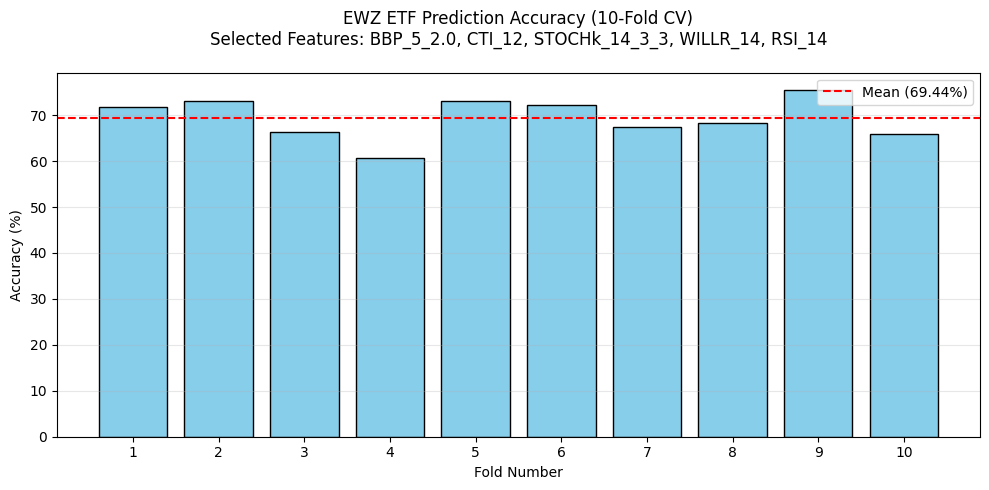

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import ta  # alternative technical analysis library

def download_etf_data(ticker="EWZ"):
    """Download ETF data matching the paper's timeframe"""
    data = yf.download(
        ticker,
        start="2009-12-12",
        end="2020-01-01",
        auto_adjust=False,
        progress=False
    )
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel("Ticker")
    return data

def calculate_technical_indicators(df):
    """Calculate technical indicators without pandas_ta"""
    # RSI 14
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

    # Stochastic Oscillator %K (14,3)
    stoch = ta.momentum.StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3
    )
    df['STOCHk_14_3_3'] = stoch.stoch()

    # Williams %R 14
    willr = ta.momentum.WilliamsRIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], lbp=14
    )
    df['WILLR_14'] = willr.williams_r()

    # Bollinger Bands %B (5, 2.0 std)
    bb = ta.volatility.BollingerBands(close=df['Close'], window=5, window_dev=2)
    df['BBP_5_2.0'] = bb.bollinger_pband()

    # CTI 12 (Commodity Channel Index, as close substitute)
    cci = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=12)
    df['CTI_12'] = cci.cci()

    # AOBV LR 2 (Approximate On Balance Volume with linear regression slope over 2 days)
    # Since ta doesn't have AOBV directly, approximate with On-Balance Volume slope
    obv = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
    df['AOBV_LR_2'] = obv.rolling(window=2).apply(lambda x: np.polyfit(range(2), x, 1)[0], raw=True)

    # EBSW 40 10 (Ehlers Bandpass filter approx with Hilbert Transform or custom - simplified here)
    # Not available in ta - we can approximate with rolling mean difference as placeholder
    df['EBSW_40_10'] = df['Close'].rolling(window=40).mean() - df['Close'].rolling(window=10).mean()

    # Binary indicators INC_1 and DEC_1
    df['INC_1'] = (df['Close'].diff(1) > 0).astype(int)
    df['DEC_1'] = (df['Close'].diff(1) < 0).astype(int)

    return df.dropna()

def create_target_variable(df):
    """Create binary target variable Γ(t)"""
    df['Gamma'] = np.where(df['Open'].diff() > 0, 1, -1)
    return df.dropna()

def select_features(X, y, n_features=5):
    """Select top n features based on Pearson correlation"""
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    correlations = pd.Series(
        [np.corrcoef(X_scaled[:, i], y)[0, 1] for i in range(X_scaled.shape[1])],
        index=X.columns
    ).abs()

    top_features = correlations.nlargest(n_features).index
    return X[top_features], top_features

def train_mlp(X_train, y_train):
    """Train MLP classifier with paper's parameters"""
    mlp = MLPClassifier(
        hidden_layer_sizes=(int((X_train.shape[1] + len(np.unique(y_train))) / 2),),
        activation='logistic',
        solver='lbfgs',
        learning_rate='adaptive',
        learning_rate_init=0.03,
        max_iter=5000,
        random_state=42,
        early_stopping=False
    )
    mlp.fit(X_train, y_train)
    return mlp

def main():
    # 1. Data Pipeline
    ewz = download_etf_data()
    ewz = calculate_technical_indicators(ewz)
    ewz = create_target_variable(ewz)

    # 2. Prepare features and target
    features = ['AOBV_LR_2', 'BBP_5_2.0', 'CTI_12', 'EBSW_40_10',
               'INC_1', 'DEC_1', 'RSI_14', 'STOCHk_14_3_3', 'WILLR_14']
    X = ewz[features]
    y = ewz['Gamma']

    # 3. Feature selection
    X_selected, selected_features = select_features(X, y, n_features=5)
    print(f"Selected Features: {list(selected_features)}")

    # 4. Cross-validation
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_selected, y), 1):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        mlp = train_mlp(X_train, y_train)
        y_pred = mlp.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    # 5. Results
    results = pd.DataFrame({
        'Fold': range(1, 11),
        'Accuracy (%)': [round(acc*100, 2) for acc in accuracies]
    })
    mean_accuracy = np.mean(accuracies) * 100

    print("\nCross-Validation Results:")
    print(results.to_string(index=False))
    print(f"\nMean Accuracy: {mean_accuracy:.2f}%")

    # 6. Visualization
    plt.figure(figsize=(10, 5))
    plt.bar(results['Fold'], results['Accuracy (%)'], color='skyblue', edgecolor='black')
    plt.axhline(mean_accuracy, color='red', linestyle='--', label=f'Mean ({mean_accuracy:.2f}%)')
    plt.title('EWZ ETF Prediction Accuracy (10-Fold CV)\nSelected Features: ' +
              ', '.join(selected_features), pad=20)
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


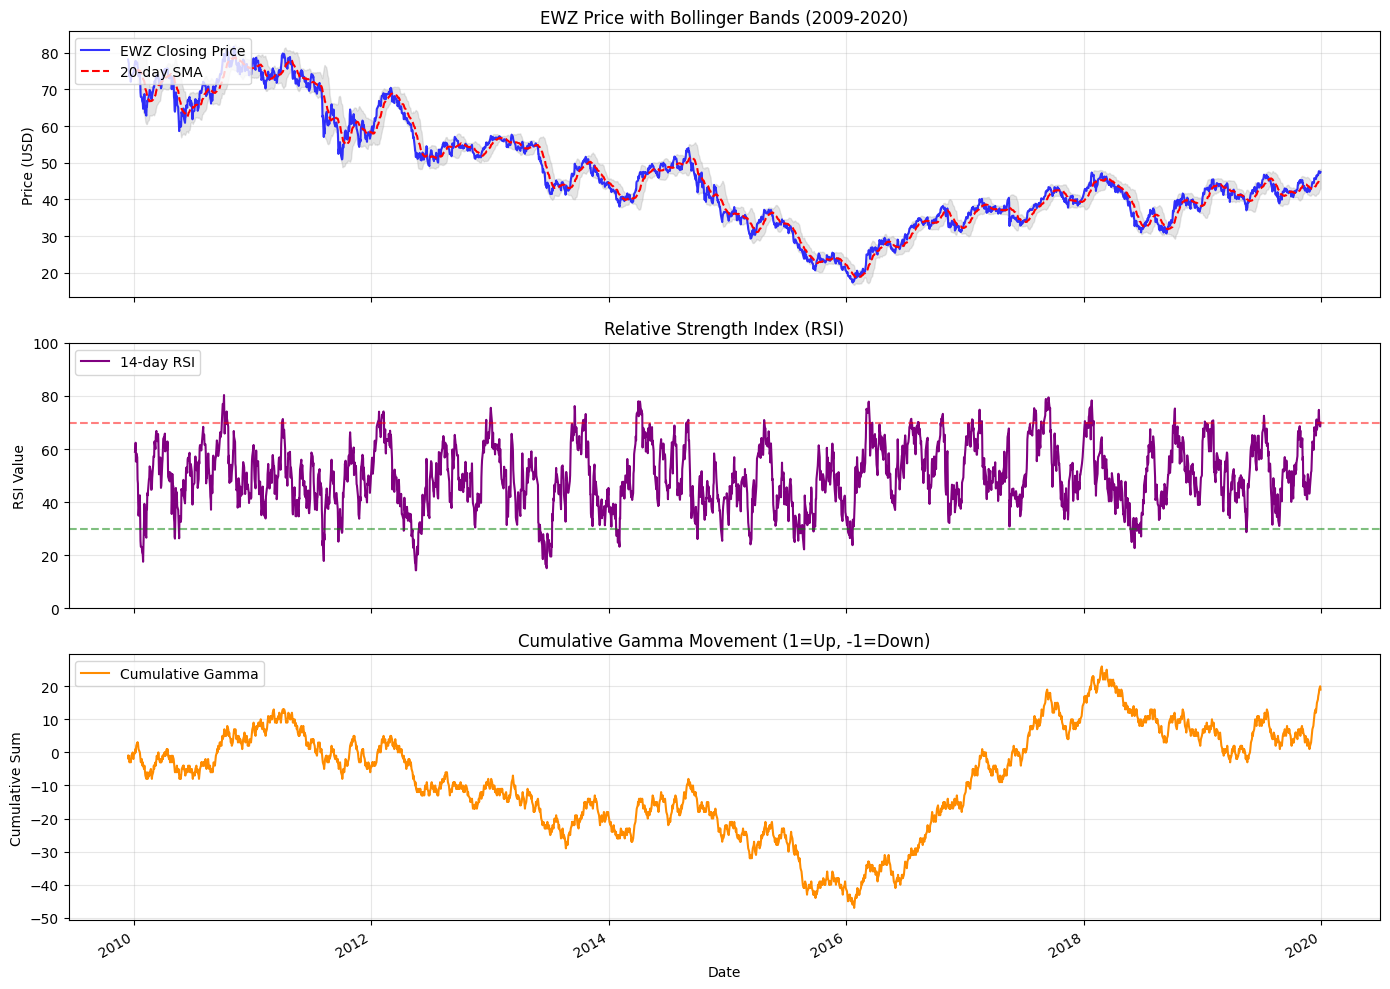

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from matplotlib.ticker import FuncFormatter

# Download data
ewz = yf.download("EWZ", start="2009-12-12", end="2020-01-01", auto_adjust=False)
if isinstance(ewz.columns, pd.MultiIndex):
    ewz.columns = ewz.columns.droplevel("Ticker")

# Calculate technical indicators
ewz['SMA_20'] = ta.trend.sma_indicator(ewz['Close'], window=20)
ewz['RSI_14'] = ta.momentum.rsi(ewz['Close'], window=14)
bbands = ta.volatility.BollingerBands(ewz['Close'], window=20, window_dev=2)
ewz['BB_upper'] = bbands.bollinger_hband()
ewz['BB_lower'] = bbands.bollinger_lband()

# Create figure with 3 subplots
plt.figure(figsize=(14, 10))

# 1. Price and Moving Averages (Figure 2 in paper)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(ewz.index, ewz['Close'], label='EWZ Closing Price', color='blue', alpha=0.8)
ax1.plot(ewz.index, ewz['SMA_20'], label='20-day SMA', color='red', linestyle='--')
ax1.fill_between(ewz.index, ewz['BB_upper'], ewz['BB_lower'], color='gray', alpha=0.2)
ax1.set_title('EWZ Price with Bollinger Bands (2009-2020)', fontsize=12)
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. RSI Indicator (Similar to momentum analysis in paper)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(ewz.index, ewz['RSI_14'], label='14-day RSI', color='purple')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
ax2.set_title('Relative Strength Index (RSI)', fontsize=12)
ax2.set_ylabel('RSI Value')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Cumulative Gamma (Figure 3 in paper)
ewz['Gamma'] = np.where(ewz['Open'].diff() > 0, 1, -1)
ewz['Cumulative_Gamma'] = ewz['Gamma'].cumsum()

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(ewz.index, ewz['Cumulative_Gamma'], label='Cumulative Gamma', color='darkorange')
ax3.set_title('Cumulative Gamma Movement (1=Up, -1=Down)', fontsize=12)
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Sum')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

# Format x-axis
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Save and show
plt.savefig('ewz_technical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()